# Electronic Structure in a Quantum Computer Framework

## Quantum Computer Framework and Connection to Chemistry


Classical computers use a bit representation to encode information and instructions. Each of these bits encode 1 or 0 depending on whether they are on or off. Analogously, a quantum computer can encode information in terms of $|0\rangle$ and $|1\rangle$ states, but also allows entanglement between each of the states. This entanglement is beneficial to chemistry problems as electrons interact with other electrons and these interactions are often correlated and an important factor in molecular properties. While quantum chemistry frameworks exist to address the problem of electronic correlation, these methods are often computationally expensive due to poor scaling with system size. Thus, a quantum computer framework to solve chemical problems may allow more efficient calculations for properties of chemical interest and higher accuracy (due to the possibility of entanglement between different quantum computer states).

Thus, this tutorial will focus on

*   Solving an electronic structure in a classical computer
*   Encoding a problem into a quantum computer form (3 steps)
**  Molecular Orbital Basis Transformation (can be done as a blackbox)
**  Second Quantization (can be done as a blackbox)
**  Qubit Encoding - Jordan-Wigner Map
*   Ansatz representation - Unitary Coupled Cluster with Singles, Doubles Excitations (UCCSD)

with each step exemplified by application to $H_2$.



## Library Installations

In [39]:
!pip install qiskit[all]
!pip install pyscf
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.6.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.3
    Uninstalling matplotlib-3.6.3:
      Successfully uninstalled matplotlib-3.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-experiments 0.4.0 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


## The Variational Quantum Eigensolver

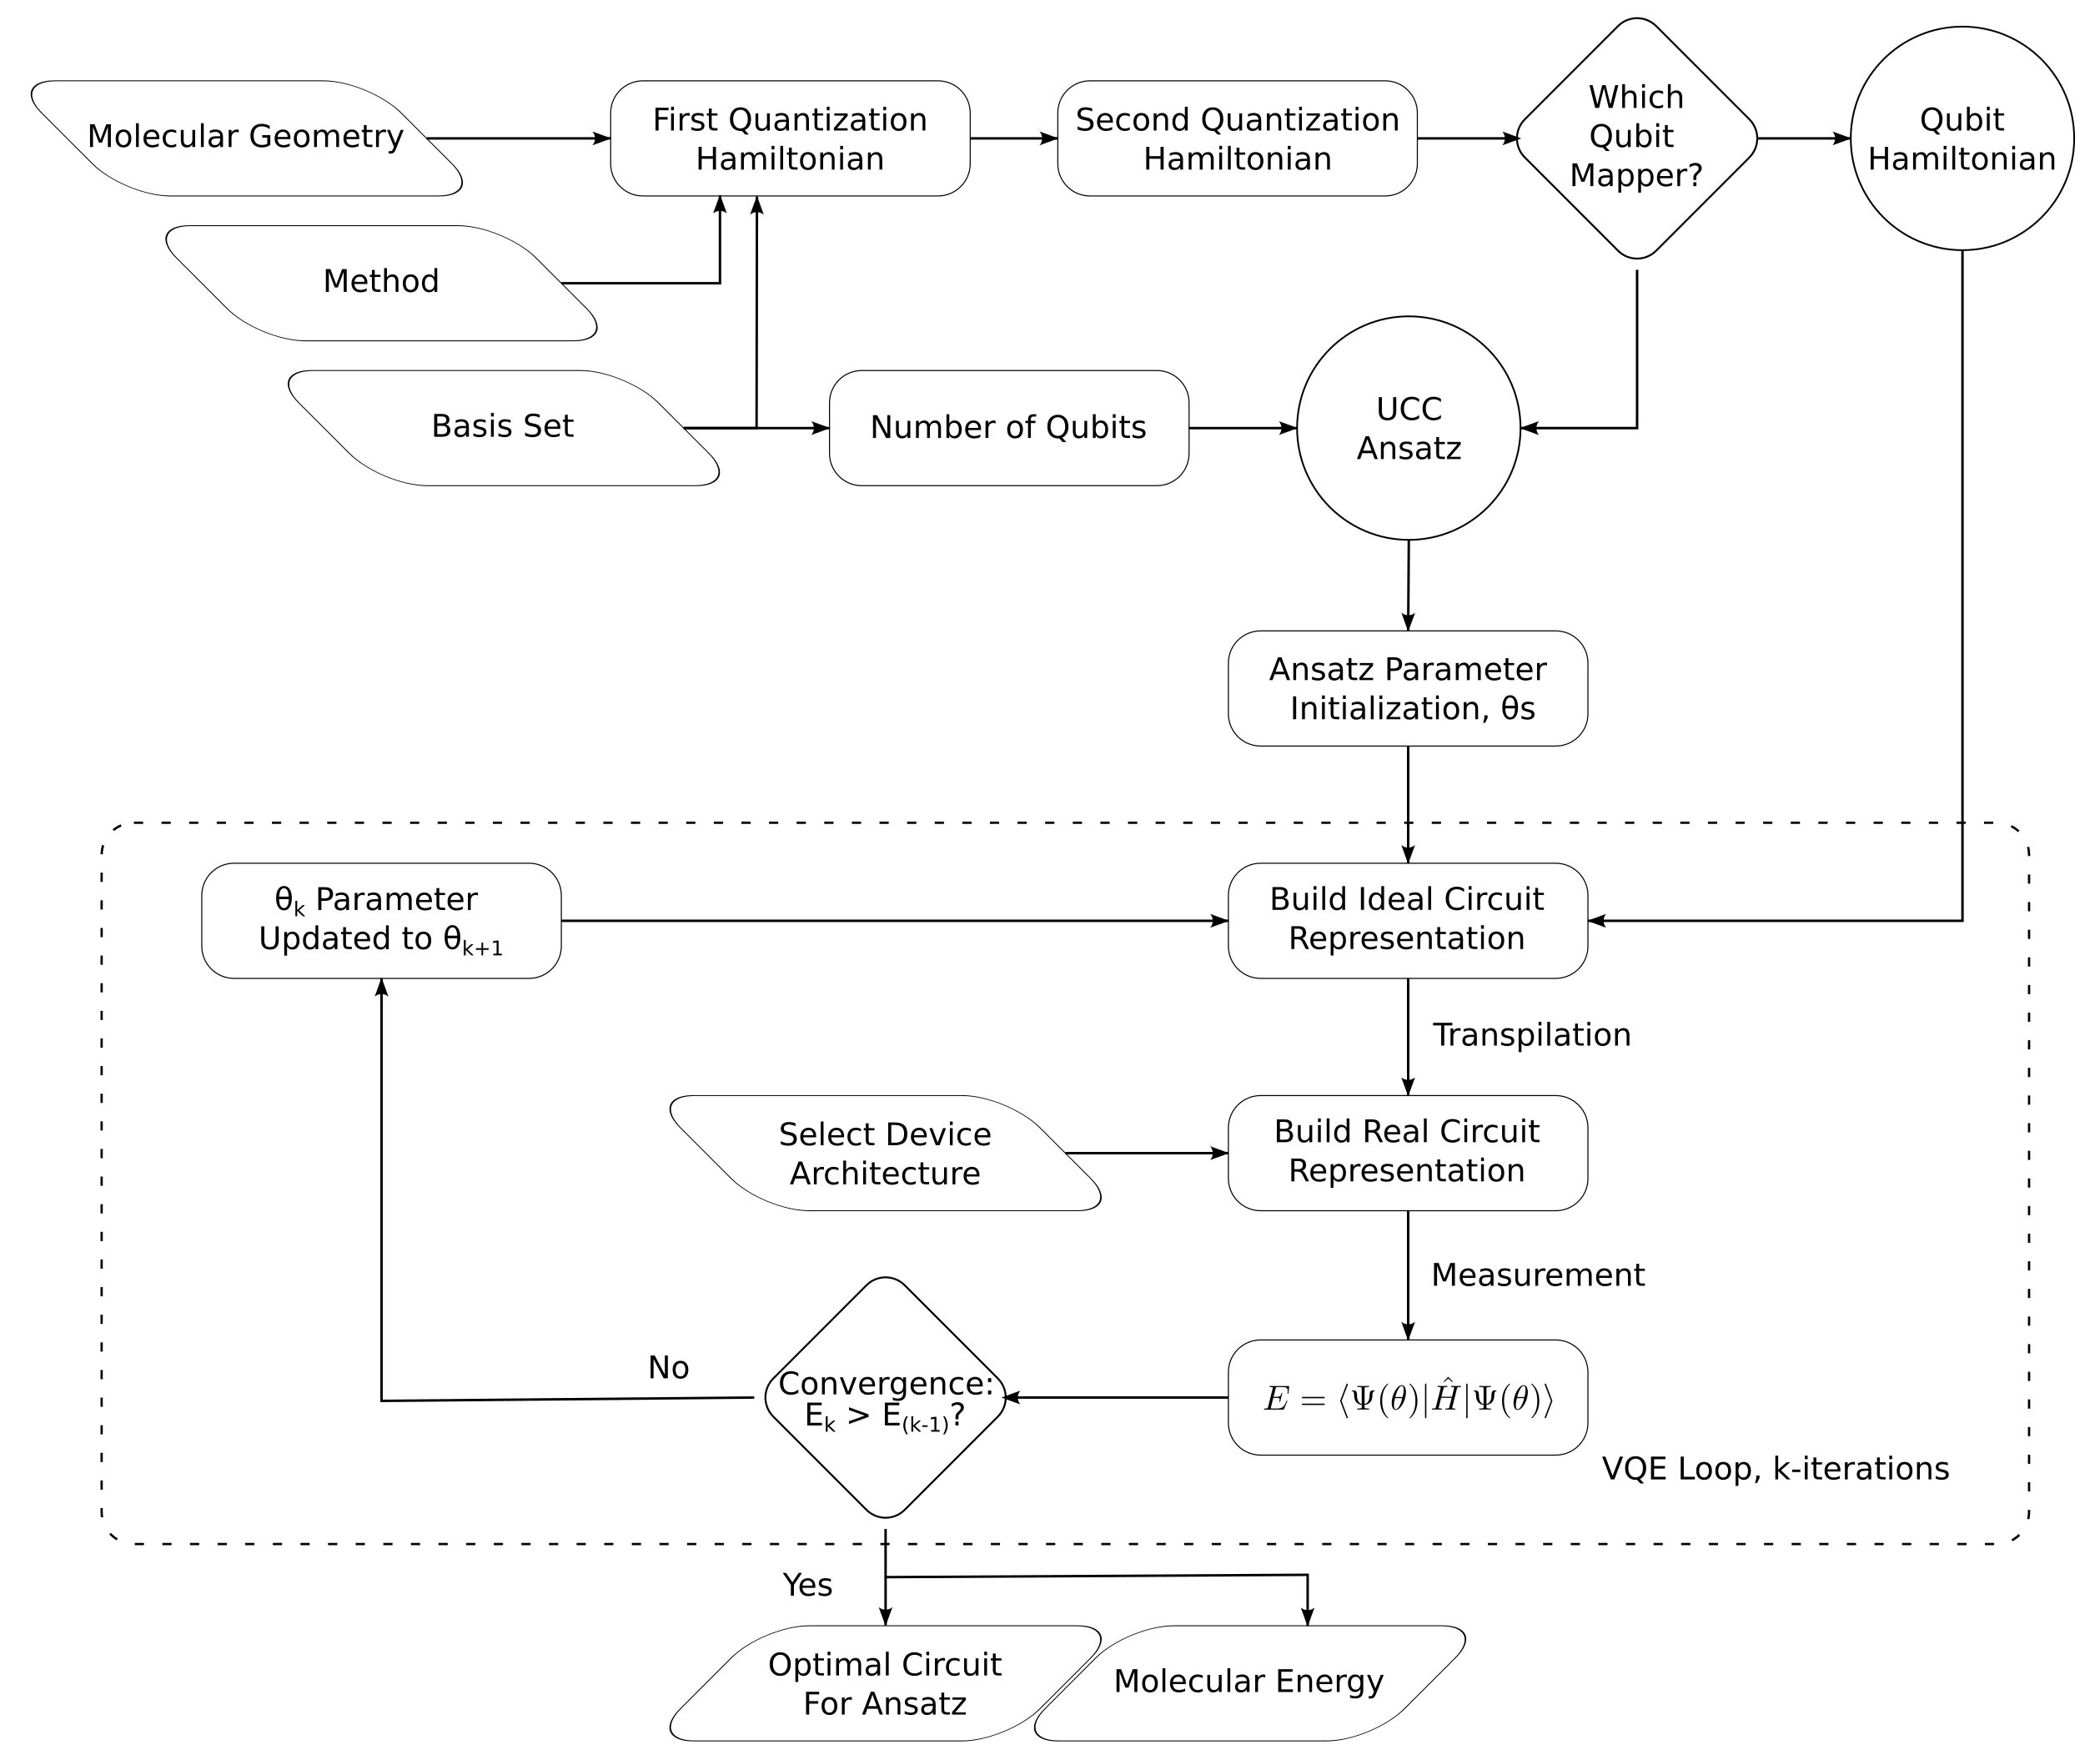

## VQE Example - $H_2$ 



This section is based on the [`qiskit_nature chemistry tutorial #3`](https://github.com/Qiskit/qiskit-nature/blob/main/docs/tutorials/03_ground_state_solvers.ipynb), which applies the VQE algorithm within the qiskit framework to the hydrogen molecule. The scheme below outlines the steps necessary to perform the calculation.

Note that the current class structure to perform a VQE calculation may be subject to change. In the version used in this tutorial each of the objects shoul should be organized in the following manner:

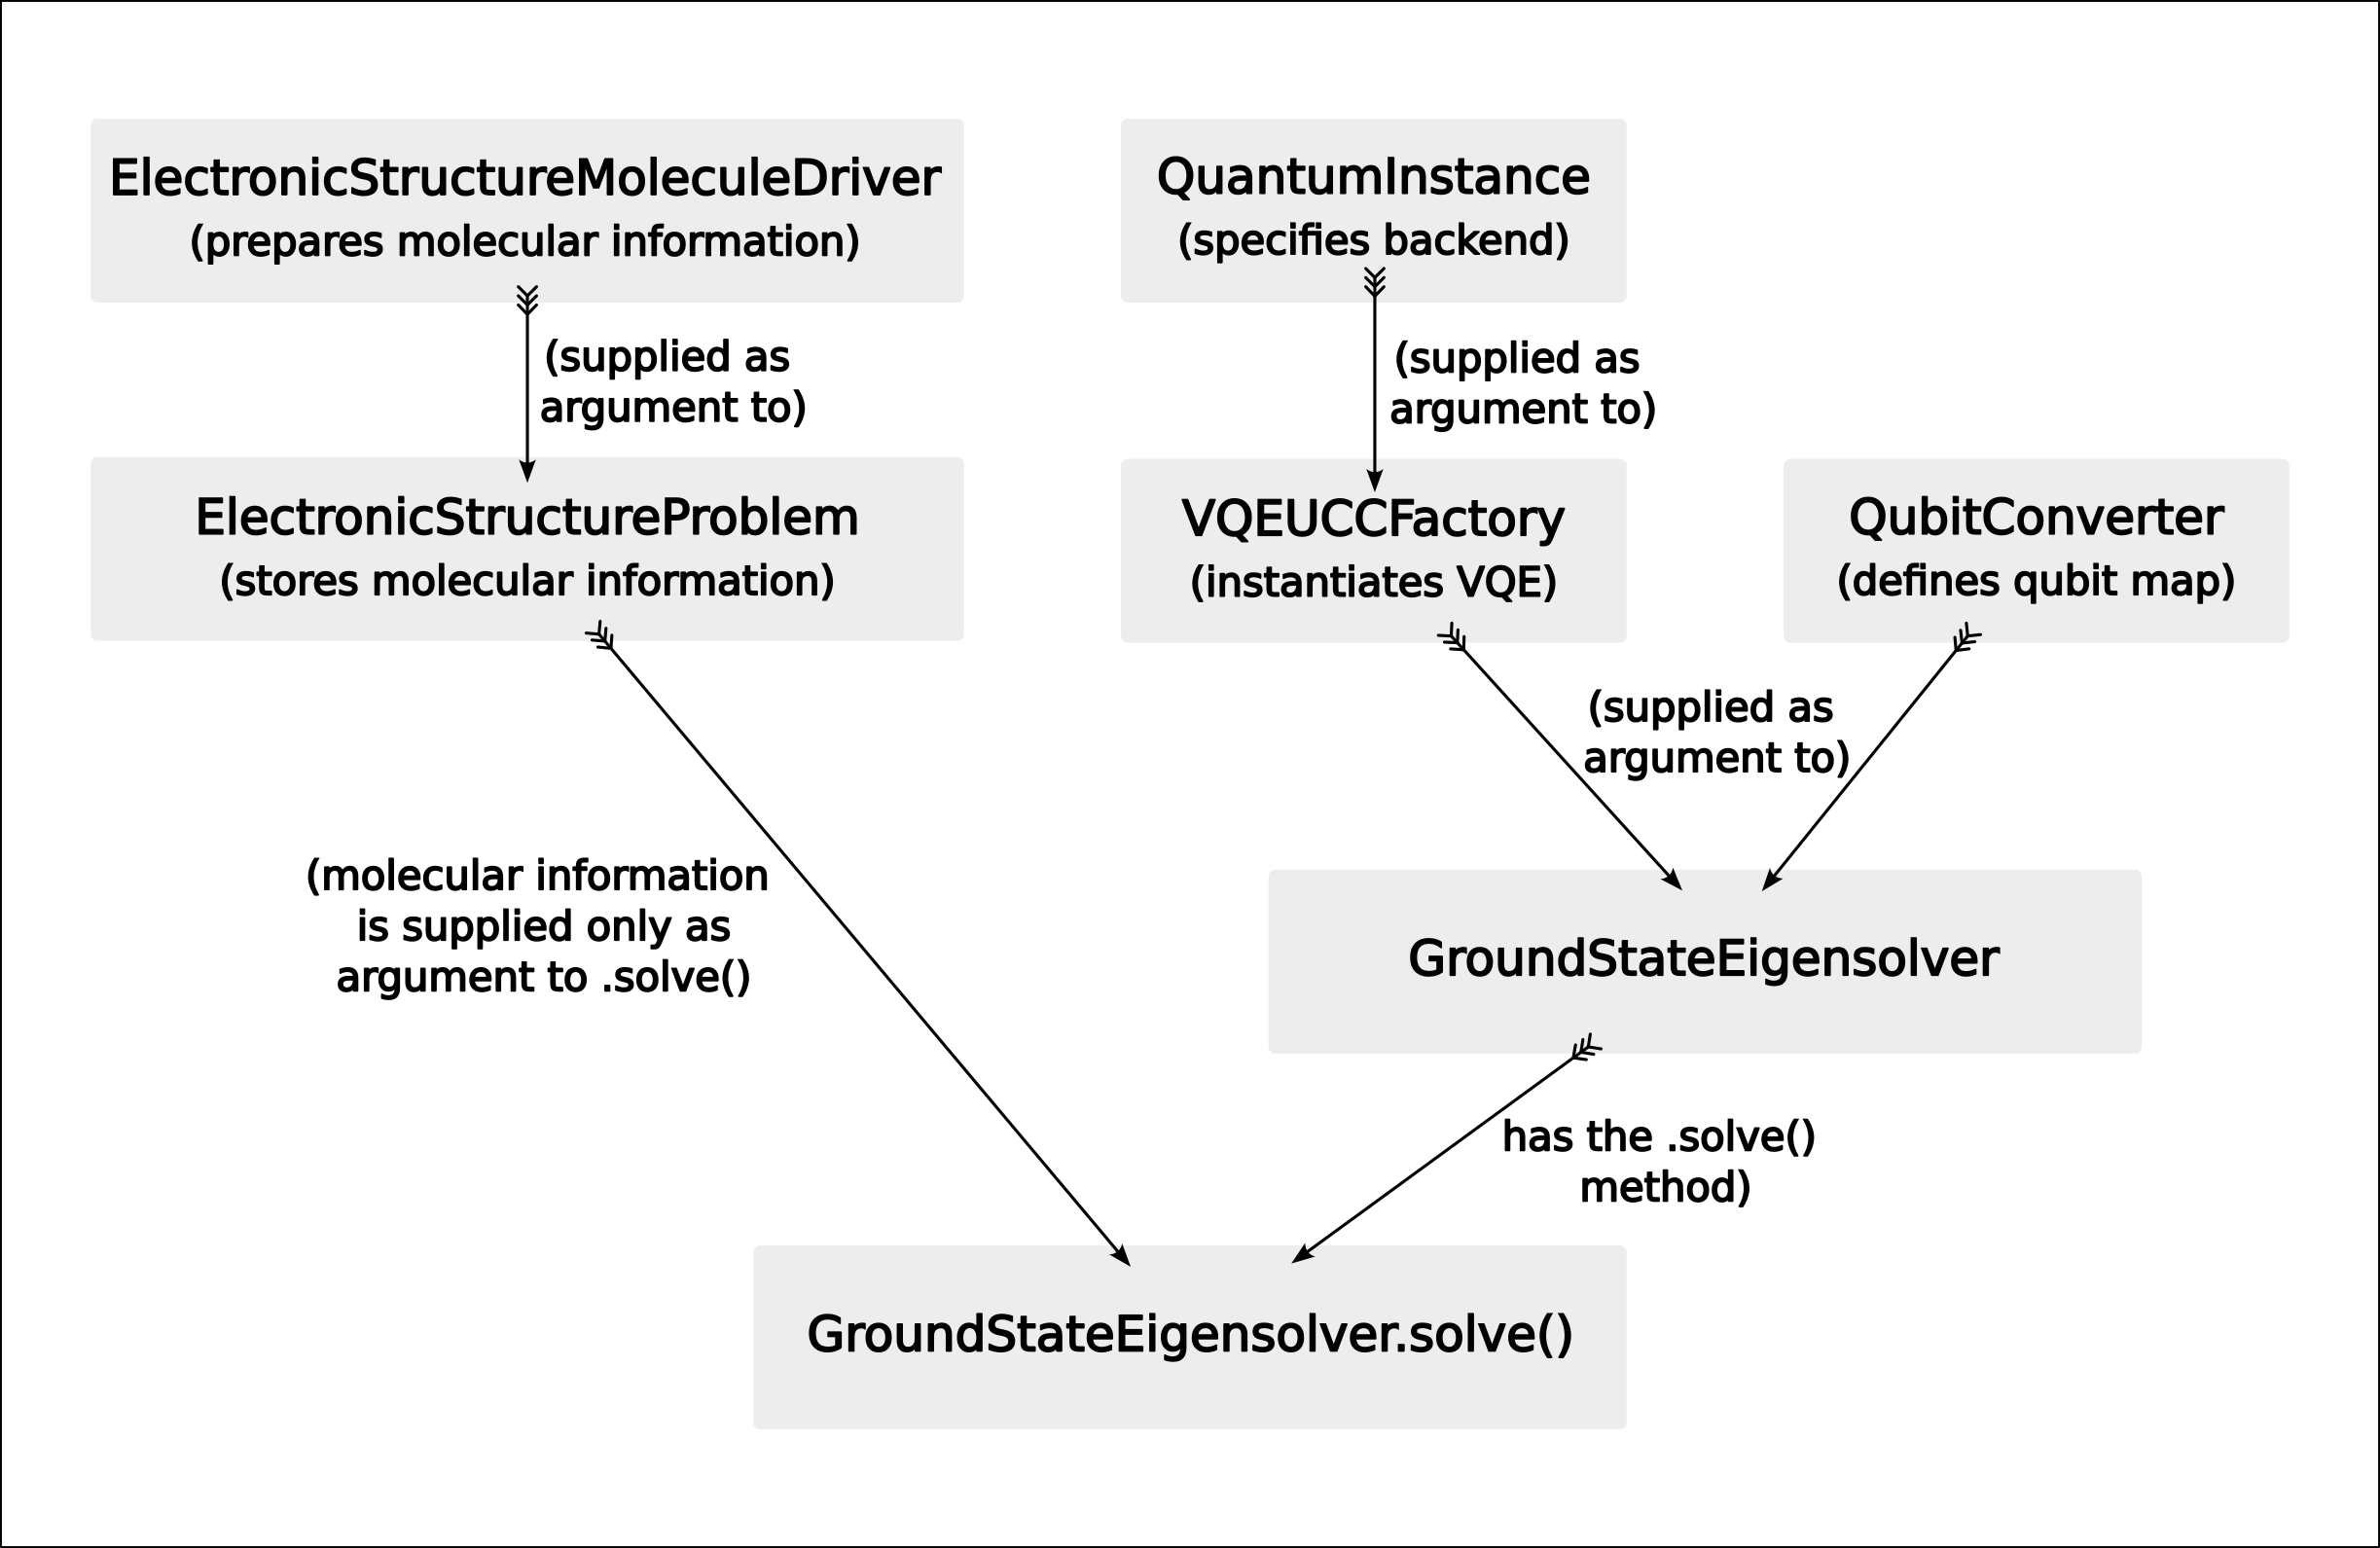

First we import the `Molecule` object from the `qiskit_nature.drivers` module. This can be supplied with a list of lists object containing the atomic `geometry`, the `charge` for the system and spin `multiplicity` (singlet = 1).

In [40]:
from qiskit_nature.drivers import Molecule

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.71414]]], charge=0, multiplicity=1
)

Then we use the `ElectronicStructureMoleculeDriver` object to instantiate a electronic structure calculation on a classical computer framework. Note that the default method for this calculation is Restricted Hartree-Fock, but other methods can be seen [here](https://qiskit.org/documentation/nature/stubs/qiskit_nature.drivers.second_quantization.MethodType.html#qiskit_nature.drivers.second_quantization.MethodType). Arguments provided include the `molecule` object produced above, the `basis` set (in this case `sto3g`, which contains a 1s spatial orbital for each hydrogen atom) and a specification of the `driver_type` as `ElectronicStructureDriverType.PYSCF` from the `qiskit_nature.drivers.second_quantization` module. Thus PySCF is used as the classical computer electronic structure software.

In [41]:
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF 
)

This driver is then supplied as an argument to the `ElectronicStructureProblem` object for encoding into a form amenable for further processing.

In [42]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

es_problem = ElectronicStructureProblem(driver)
print(es_problem)

We define a `QuantumInstance` using the `Aer` module to choose a backend and simulate the quantum computer framework on a classical machine.

In [43]:
from qiskit.utils import QuantumInstance
from qiskit import Aer

quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))

We import the `VQEUCCFactory` class which encodes the Variational Quantum Eigensolver algorithm, and is supplied with the `quantum_instance` backend chosen for the quantum part of the calculation.

In [44]:
from qiskit_nature.algorithms import VQEUCCFactory

vqe_solver = VQEUCCFactory(quantum_instance=quantum_instance)

Additionally, we use the `GroundStateEigensolver` object to solve the minimization problem for the ground state. As an argument we supplied the `qubit_converter` allowing encoding of the attributes of the classical computer electronic structure calculation into the qubit basis, alongside the specification of the `vqe_solver` object for quantum simulation. **Note that at this time no molecular information has been provided to any of these objects.**

In [45]:
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

qubit_converter = QubitConverter(JordanWignerMapper())
calc = GroundStateEigensolver(qubit_converter, vqe_solver)

Obtaining the VQE electronic structure result requires calling the method `solve` from the `GroundStateEigensolver` class for the particular electronic structure problem, `es_problem`(which contains the molecular information):

In [46]:
res = calc.solve(es_problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.877922738687
  - computed part:      -1.877922738687
~ Nuclear repulsion energy (Hartree): 0.740999259137
> Total ground state energy (Hartree): -1.13692347955
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.34952901]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.34952903]
    - computed part:      [0.0  0.0  1.34952903]
  > Dipole moment (a.u.): [0.0  0.0  -0.00000002]  Total: 0.00000002
                 (debye): [0.0  0.0  -0.00000005]  Total: 0.00000005
 


And this completes the application of the VQE algorithm to the $H_2$ molecule.

### ADAPT-VQE

Here we show how Qiskit's convenient [`AdaptVQE`](https://qiskit.org/documentation/nature/stubs/qiskit_nature.algorithms.AdaptVQE.html) class can be used to solve the same $H_2$ example problem. Here, we show a schematic that outlines the flow of the ADAPT-VQE algorithm to highlight how it differs from traditional VQE. 

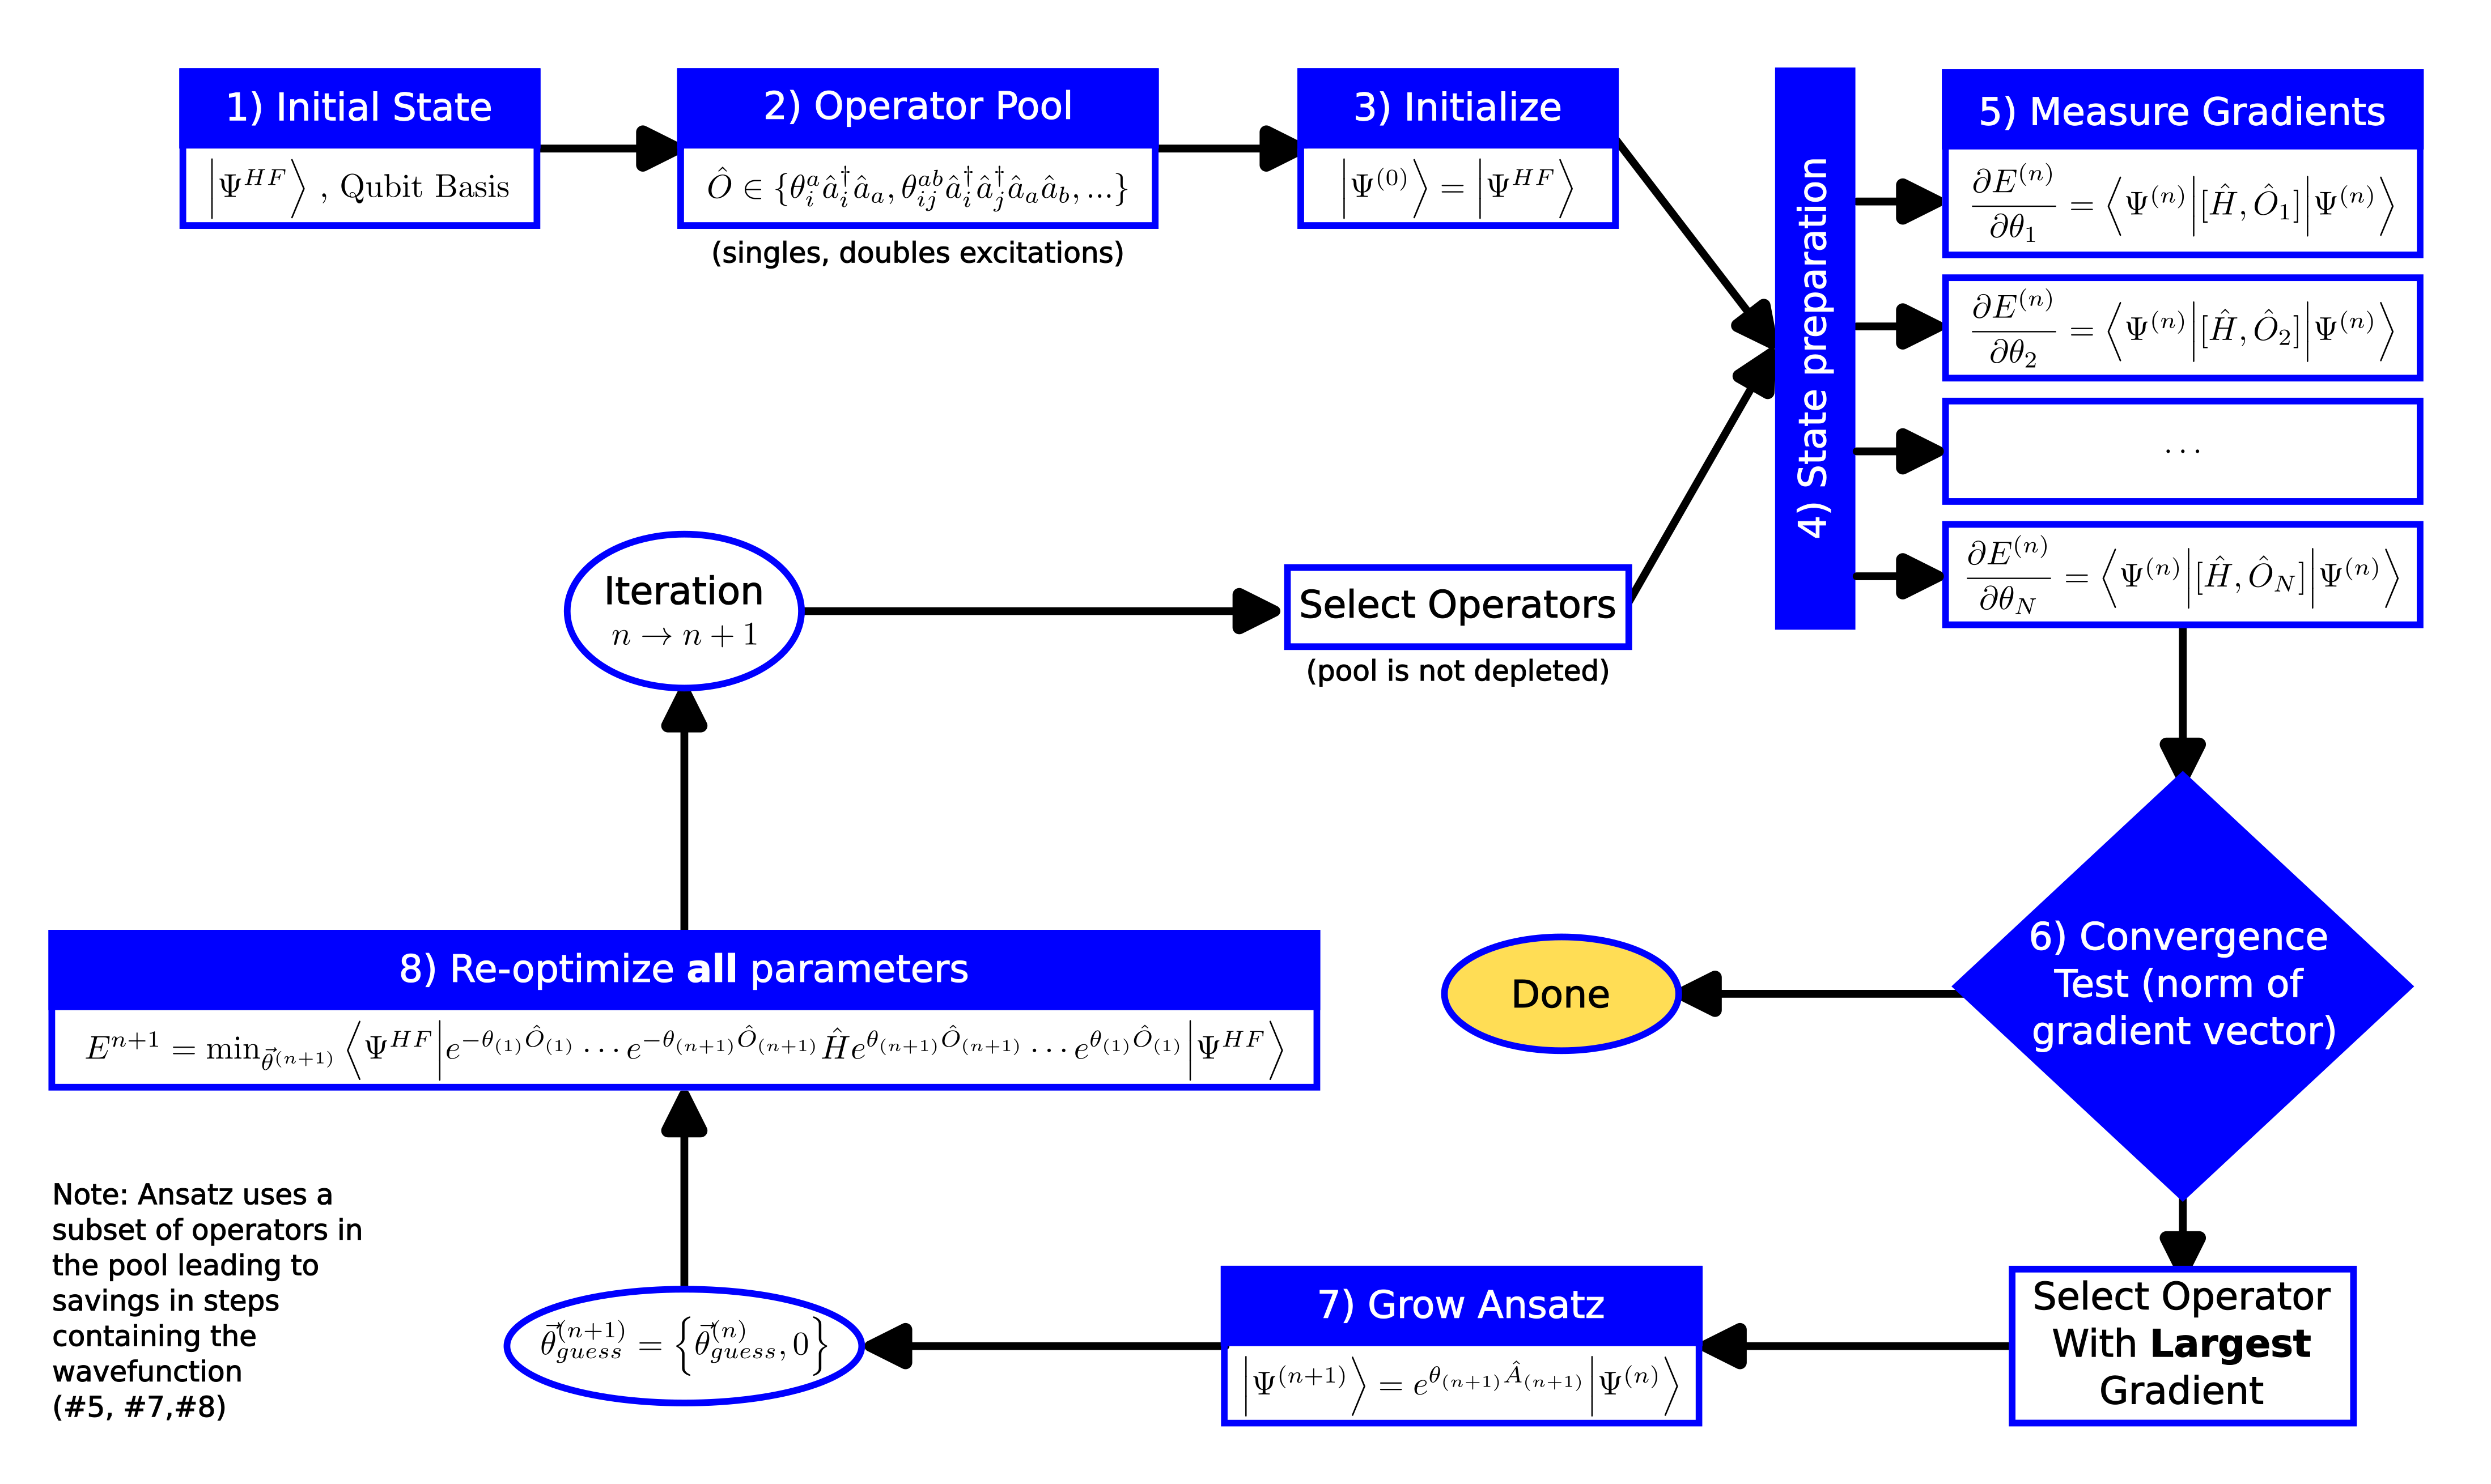

Image adapted from [Grimsley, H. R.; Economou, S. E.; Barnes, E.; Mayhall, N. J. An Adaptive Variational Algorithm for Exact Molecular Simulations on a Quantum Computer. Nat Commun 2019, 10 (1), 3007.](https://doi.org/10.1038/s41467-019-10988-2)

To accomplish this calculation, we import the `AdaptVQE` from the `qiskit_nature.algorithms` module. The arguments are similar to the VQE, except additional arguments are supplied such as `threshold` for the convergence test, `delta` for the parameter change and `max_iterations` to define the number of ADAPT cycles cuttoff.

In [47]:
from qiskit_nature.algorithms import AdaptVQE

adapt_calc = AdaptVQE(qubit_converter, vqe_solver, threshold=1e-1, delta=1e-2, max_iterations=100)

Analogously to VQE, we call the `solve` method using the choice of molecular information encoded in the electronic structure problem object, `es_problem`.

In [48]:
adapt_res = adapt_calc.solve(es_problem)

print(adapt_res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.877922738687
  - computed part:      -1.877922738687
~ Nuclear repulsion energy (Hartree): 0.740999259137
> Total ground state energy (Hartree): -1.136923479551
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.34952901]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.34952901]
    - computed part:      [0.0  0.0  1.34952901]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  -0.00000001]  Total: 0.00000001
 


In [49]:
from pyscf import gto, scf, cc

In [50]:
vqe_energy = {}
adapt_vqe_energy = {}
hf_energy = {}
ccsd_energy = {}


for i in range(5,30,1):
    bond_length = i * 0.71414 / 10
    molecule = Molecule(
        geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, bond_length]]], charge=0, multiplicity=1
    )
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF 
    )
    es_problem = ElectronicStructureProblem(driver)
    quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
    vqe_solver = VQEUCCFactory(quantum_instance=quantum_instance)
    qubit_converter = QubitConverter(JordanWignerMapper())
    calc = GroundStateEigensolver(qubit_converter, vqe_solver)
    res = calc.solve(es_problem)
    vqe_energy[bond_length] = res.total_energies[0]


    adapt_calc = AdaptVQE(qubit_converter, vqe_solver, threshold=1e-1, delta=1e-2, max_iterations=100)
    adapt_res = adapt_calc.solve(es_problem)
    adapt_vqe_energy[bond_length] = adapt_res.total_energies[0]


    molecule = gto.M(atom='H 0 0 0; H 0 0 {}'.format(bond_length), basis='sto3g')
    UHF_calc = scf.UHF(molecule).run()
    total_uhf_energy = UHF_calc.e_tot
    hf_energy[bond_length] = total_uhf_energy

    ccsd_calc = cc.CCSD(UHF_calc).run() # this is UCCSD
    total_ccsd_energy = ccsd_calc.e_tot
    ccsd_energy[bond_length] = total_ccsd_energy

converged SCF energy = -0.801142436761327  <S^2> = 0  2S+1 = 1
E(UCCSD) = -0.8100863271858585  E_corr = -0.008943890424531628
converged SCF energy = -0.955744349825872  <S^2> = -4.4408921e-16  2S+1 = 1
E(UCCSD) = -0.9661497998820059  E_corr = -0.01040545005613351
converged SCF energy = -1.04290509541944  <S^2> = 2.220446e-16  2S+1 = 1
E(UCCSD) = -1.055065916373917  E_corr = -0.01216082095448013
converged SCF energy = -1.08992103373755  <S^2> = 0  2S+1 = 1
E(UCCSD) = -1.104152689598485  E_corr = -0.01423165586093327
converged SCF energy = -1.11179179203356  <S^2> = -4.4408921e-16  2S+1 = 1
E(UCCSD) = -1.128434426870893  E_corr = -0.0166426348373294
converged SCF energy = -1.11750216688886  <S^2> = 0  2S+1 = 1
E(UCCSD) = -1.136923612624393  E_corr = -0.01942144573552994
converged SCF energy = -1.11273503067124  <S^2> = -4.4408921e-16  2S+1 = 1
E(UCCSD) = -1.135336727911578  E_corr = -0.02260169724033601
converged SCF energy = -1.10115415487252  <S^2> = 0  2S+1 = 1
E(UCCSD) = -1.127380086

In [51]:
bond_length = 1.0
molecule = gto.M(atom='H 0 0 0; H 0 0 {}'.format(bond_length), basis='sto3g')
UHF_calc = scf.UHF(molecule).run()
total_energy = UHF_calc.e_tot
# hf_energy[bond_length] = scf_result
mycc = cc.CCSD(UHF_calc).run() # this is UCCSD
print('UCCSD total energy = ', mycc.e_tot)

converged SCF energy = -1.06610864931794  <S^2> = 0  2S+1 = 1
E(UCCSD) = -1.101150330244479  E_corr = -0.03504168092654206
UCCSD total energy =  -1.1011503302444787


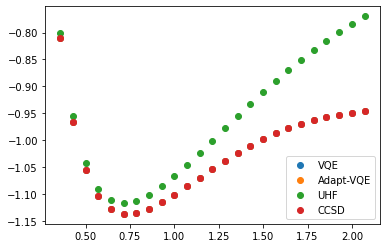

In [53]:
import matplotlib.pyplot as plt

# print(electronic_energy)
plt.scatter(vqe_energy.keys(), vqe_energy.values(), label='VQE')
plt.scatter(adapt_vqe_energy.keys(), adapt_vqe_energy.values(), label='Adapt-VQE')
plt.scatter(hf_energy.keys(), hf_energy.values(), label='UHF')
plt.scatter(ccsd_energy.keys(), ccsd_energy.values(), label='CCSD')
plt.legend()
plt.show()